In [1]:
import os
import time
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
from skimage.transform import resize
from photutils import CircularAperture, CircularAnnulus
from usid_processing import parallel_compute
from functools import partial

import galsim

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'legend.fontsize': 14})
rcParams.update({'legend.title_fontsize': 16})
rcParams.update({'axes.titlesize': 16})

from utils import *

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
draw = True
save = False
mask_strip = True
wid_strip, n_strip = 5, 12
dir_name = "./run"

In [17]:
# Image Parameter
image_size = 400
n_star = 350
pixel_scale = 2.5                                # arcsec/pixel
psf_pixel_scale = 1.5                            # arcsec/pixel

# PSF Parameters
beta_psf = 5                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n = 3.                     # true power index
frac = 0.25                 # fraction of power law component
theta_t = 5.                # radius at which power law is flattened, in arcsec

theta_t_pix = theta_t/pixel_scale          # flattened radius, in pix
theta_t_psf_pix = theta_t/psf_pixel_scale  # flattened radius in psf, in pix
a = (theta_t_psf_pix)**n                   # normalization

noise_variance = 10                        # sky variance
mu = 884                                   # sky mean
sigma = np.sqrt(noise_variance)            # sky stddev

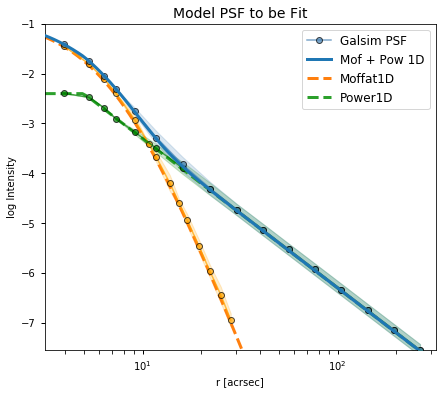

In [19]:
############################################
# Setup PSF
############################################

def Generate_PSF_pow_Galsim(contrast, n=n, psf_scale=psf_pixel_scale, 
                            psf_size=None, min_psf_size=None, max_psf_size=None,
                            x_interpolant="lanczos3", k_interpolant="lanczos3"):
    if psf_size is None:
        a = (theta_t/psf_scale)**n
        opt_psf_size = 2 * int((contrast * a) ** (1./n))
        opt_psf_size = round_good_fft(opt_psf_size)
        psf_size = max(min_psf_size, min(opt_psf_size, max_psf_size))

    cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
    yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]

    psf_model = trunc_power2d(xx_psf, yy_psf, n, cen=cen_psf, theta0=theta_t/psf_scale, I_theta0=1) 
    image_psf = galsim.ImageF(psf_model)
    
    psf_pow = galsim.InterpolatedImage(image_psf, flux=1, scale=psf_scale,
                                       x_interpolant=x_interpolant, k_interpolant=k_interpolant)
    return psf_pow, psf_size

# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_pow_1, psf_size_1 = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_size=512,
                                                psf_scale=psf_pixel_scale)
psf_pow_2, psf_size_2 = Generate_PSF_pow_Galsim(contrast=1e5, n=n,
                                                psf_size=image_size*2, 
                                                psf_scale=psf_pixel_scale)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-6)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

if draw:
    frac = 0.15
    star_psf_2 = (1-frac) * psf_mof + frac * psf_pow_2 
    
    img_pow_2 = psf_pow_2.drawImage(scale=pixel_scale, method="no_pixel").array
    img_mof = psf_mof.drawImage(scale=pixel_scale, method="fft").array
    img_gs_2 = star_psf_2.drawImage(scale=pixel_scale, method="no_pixel").array
    
    plt.figure(figsize=(7,6))
    r = np.logspace(0.1,2.5,100)
    C_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / C_mof2Dto1D

    C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / C_pow2Dto1D

    
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d((1-frac)*img_mof, pix_scale=pixel_scale, seeing=2.5, 
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", color="orange")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(frac*img_pow_2, pix_scale=pixel_scale, seeing=2.5, 
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", color="g")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5,  
                                                 core_undersample=True,xunit="arcsec", yunit="intensity", label="Galsim PSF")

    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1 + comp2 * frac), ls="-", lw=3, label="Mof + Pow 1D",zorder=5)
    plt.plot(r*pixel_scale, np.log10((1-frac) * comp1), ls="--", lw=3, label="Moffat1D",zorder=1)
    plt.plot(r*pixel_scale, np.log10(comp2 * frac), ls="--",lw=3,  label="Power1D")

    plt.xscale("log")
    plt.axvline(theta_t_pix,color="k",ls="--")
    plt.title("Model PSF to be Fit",fontsize=14)
    
    plt.legend(fontsize=12)
    plt.ylim(np.log10(z_rbin[-1]),-1)
    if save:
        plt.savefig("%s/Model.png"%dir_name,dpi=150)
        plt.close()


# of medium bright (flux:6e+04~8.5e+05) stars: 28 
# of very bright (flux>8.5e+05) stars : 4
Not many bright stars, truth and mock will be generated in serial.


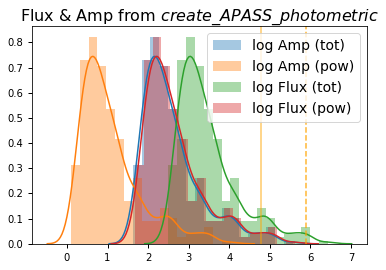

In [21]:
############################################
# Distribution
############################################

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Generate randomn star positions
np.random.seed(88)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[(SE_cat_full.FLAGS<8)]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(512)
Flux = Flux_Auto_SE.sample(n=n_star).values

# Convert Flux to Astropy Moffat Amplitude (pixel)
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 6e4
F_verybright = 8e5
bright = Flux > F_bright
verybright = Flux > F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])
print("# of medium bright (flux:%.2g~%.2g) stars: %d "%(Flux[bright].min(), Flux[verybright].min(), num_medbright))
print("# of very bright (flux>%.2g) stars : %d"%(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    parallel = True
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")

    def map2d(f, xx, yy):
        return f(xx,yy)

    p_map2d = partial(map2d, xx=xx, yy=yy)

if draw:
    import seaborn as sns
    sns.distplot(np.log10(Amps),label="log Amp (tot)")
    Amp_pow_s = power2d_Flux2Amp(n, theta_t_pix, Flux=frac*Flux)                     
    sns.distplot(np.log10(Amp_pow_s),label="log Amp (pow)")
    sns.distplot(np.log10(Flux),label="log Flux (tot)")
    sns.distplot(np.log10(frac*Flux),label="log Flux (pow)")
    plt.axvline(np.log10(F_bright), color="orange", ls="-",alpha=0.6)
    plt.axvline(np.log10(F_verybright), color="orange", ls="--",alpha=0.8)
    plt.title("Flux & Amp from $create{\_}APASS{\_}photometric$")
    plt.legend()

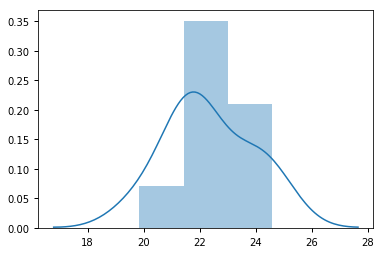

In [21]:
I_pow_s = Intensity2SB(Amp_pow_s, BKG=mu, ZP=27.1, pix_scale=pixel_scale)
sns.distplot(I_pow_s[~np.isnan(I_pow_s)],label="log Amp (pow)")

Generate noise background w/ stddev = 3.2.
Generate base image of faint stars (flux < 5.1e+04).
Total Time: 0.168s
Generate the truth image (faint stars with Moffat only).
Rendering bright stars in serial...
Total Time: 5.676s


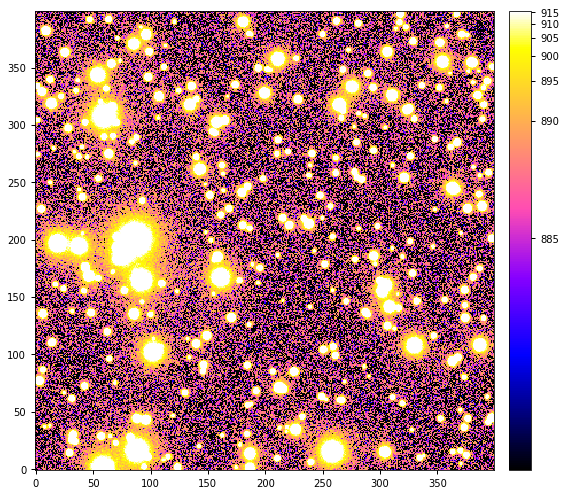

In [22]:
############################################
# Setup Image
############################################

# Setup the noise background
def make_noise_image(image_size, noise_var, random_seed=42):
    noise_image = galsim.ImageF(image_size, image_size)
    rng = galsim.BaseDeviate(random_seed)
    gauss_noise = galsim.GaussianNoise(rng, sigma=math.sqrt(noise_var))
    noise_image.addNoise(gauss_noise)  
    return noise_image.array

print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, noise_variance)


# Shift center for the purpose pf accuracy (by default galsim round to integer!)
def get_center_offset(pos):
    x_pos, y_pos = pos[0] + 1, pos[1] + 1 
    x_nominal = x_pos + 0.5
    y_nominal = y_pos + 0.5
    ix_nominal = int(math.floor(x_nominal+0.5))
    iy_nominal = int(math.floor(y_nominal+0.5))
    dx = x_nominal - ix_nominal
    dy = y_nominal - iy_nominal
    offset = galsim.PositionD(dx,dy)
    return (ix_nominal, iy_nominal), offset  

# Auxciliary function of drawing, practically devised to facilitate parallelization.
def draw_star(k, star_pos, Flux, psf_star, psf_size, full_image):
    """ Draw star #k at position star_pos[k] with Flux[k], using a combined PSF (psf_star) on full_image"""
    stamp, bounds = get_stamp_bounds(k, star_pos, Flux, psf_star, psf_size, full_image)
    full_image[bounds] += stamp[bounds]

def get_stamp_bounds(k, star_pos, Flux, psf_star, psf_size, full_image):
    """ Get stamp and boundary of star #k at position star_pos[k] with Flux[k], using a combined PSF (psf_star) on full_image"""
    pos, flux = star_pos[k], Flux[k]       
    star = psf_star.withFlux(flux)

    # Account for the fractional part of the position
    (ix_nominal, iy_nominal), offset = get_center_offset(pos)

    stamp = star.drawImage(nx=psf_size, ny=psf_size, scale=pixel_scale, offset=offset, method='no_pixel')
    stamp.setCenter(ix_nominal, iy_nominal)
    
    bounds = stamp.bounds & full_image.bounds
    
    return stamp, bounds
    
# Setup the base image for faint stars (Moffat only):
def make_base_image(image_size, star_pos, Flux):
    
    start = time.time()
    full_image0 = galsim.ImageF(image_size, image_size)
    
    # draw faint stars in Moffat with galsim in Fourier space   
    for k in range(len(star_pos)):
        draw_star(k, star_pos=star_pos, Flux=Flux,
                  psf_star=psf_mof, psf_size=64, full_image=full_image0)

    image_gs0 = full_image0.array
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    return image_gs0

print("Generate base image of faint stars (flux < %.2g)."%(Flux[~bright].max()))
image_gs0 = make_base_image(image_size, star_pos=star_pos[~bright], Flux=Flux[~bright])

                   
# Make the truth image to be fitted (Moffat+power):
def make_truth_image(image_size, star_pos, Flux, noise,
                     method="Real", parallel=parallel, saturation=4.5e4):
    
    """ Build Truth image with the position, flux and noise. 
    Two methods provided: 1) Galsim convolution in FFT and 2) Astropy model in real space. 
    [xx, yy, frac, bright, psf_mof, psf_pow is defined in the main.] """
    start = time.time()
    if method == "Galsim":
        full_image = galsim.ImageF(image_size, image_size)
                   
        for k, (pos, flux) in enumerate(zip(star_pos, Flux)): 

            if flux < 1e3:  # very faint stars, just assume truth is mofffat
                psf_star = psf_mof
            elif flux < F_verybright: 
                psf_star = (1-frac) * psf_mof + frac * psf_pow_1
            else:
                psf_star = (1-frac) * psf_mof + frac * psf_pow_2

            star = psf_star.withFlux(flux)
            (ix_nominal, iy_nominal), offset = get_center_offset(pos)

            stamp = star.drawImage(scale=pixel_scale, offset=offset, method='no_pixel')
            stamp.setCenter(ix_nominal,iy_nominal)

            bounds = stamp.bounds & full_image.bounds
            full_image[bounds] += stamp[bounds]

        image_gs = full_image.array
        image = image_gs.copy()

    elif method == "Real":
        I_theta0_pow = power2d_Flux2Amp(n, theta_t_pix, Flux=1)  ###
        moffat2d_s = np.array([models.Moffat2D(amplitude=amp, x_0=x0, y_0=y0, gamma=gamma_pix, alpha=beta_psf) 
                      for (amp, (x0,y0)) in zip(Amps, star_pos)])
        power2d_s = np.array([lambda xx, yy, cen=cen, flux=flux: trunc_power2d(xx, yy, n, 
                                                                               cen=cen, theta0=theta_t_pix,
                                                                               I_theta0=I_theta0_pow*frac*flux)  ###
                              for (flux, cen) in zip(Flux, star_pos)])
  
        # Draw stars in real space
        if not parallel:
            print("Rendering bright stars in serial...")
            image_real = np.sum([m2d(xx,yy) + p2d(xx,yy) 
                                for (m2d,p2d) in zip(moffat2d_s[Flux>1e3], power2d_s[Flux>1e3])], axis=0)
        else:
            print("Rendering bright stars in parallel...")
            func2d_s = np.concatenate([moffat2d_s[Flux>1e3], power2d_s[Flux>1e3]])
            
            image_star_s = parallel_compute(func2d_s, p_map2d, lengthy_computation=False, verbose=True)
            image_real = np.sum(image_star_s, axis=0)
            
        image = image_real.copy()
        image += image_gs0  # add faint star base
        
    image += mu + noise # add background and noise
    image[image>saturation] = saturation
        
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    
    return image

print("Generate the truth image (faint stars with Moffat only).")
image = make_truth_image(image_size, star_pos=star_pos, Flux=Flux, 
                         noise=noise_image, parallel=parallel, method="Real")

if draw:
    plt.figure(figsize=(8,7))
    im = plt.imshow(image, vmin=mu, vmax=mu+10*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    colorbar(im)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Truth.png"%dir_name,dpi=150) 
        plt.close()

Mask inner regions of stars (threshold: S/N = 2.5)
Use sky strips crossing very bright stars


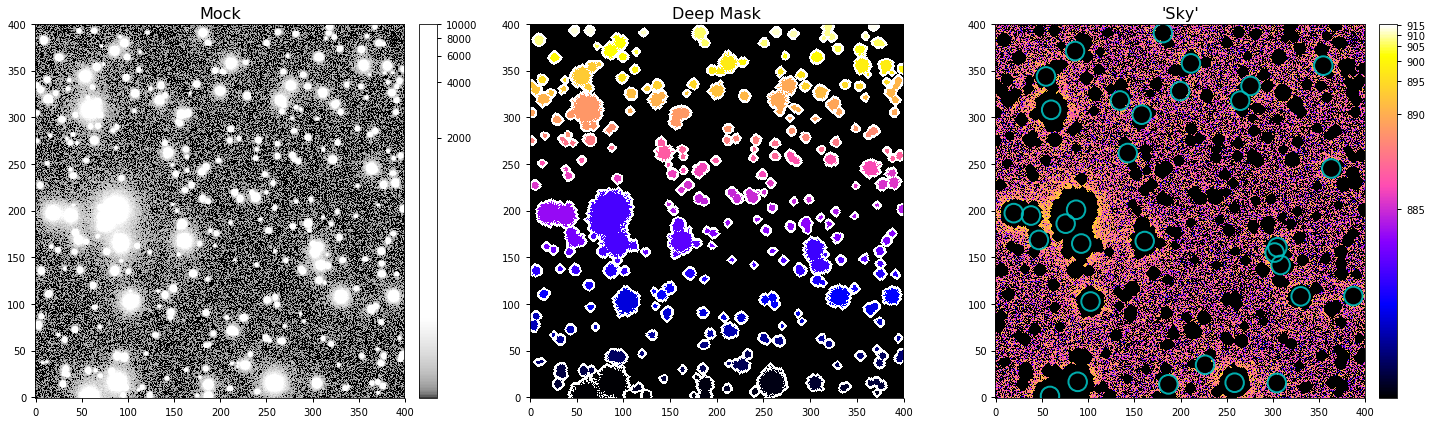

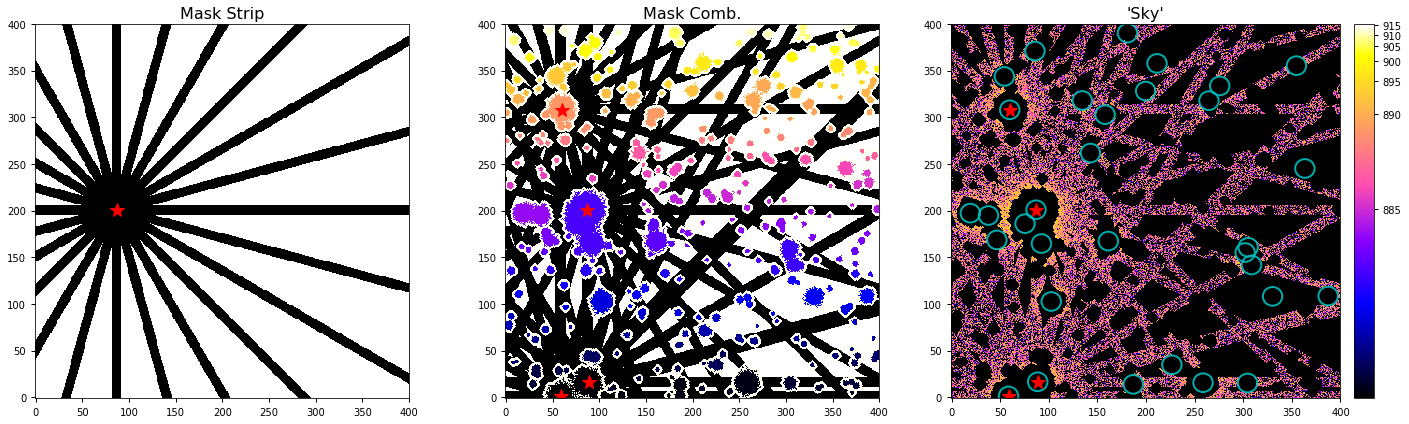

In [24]:
############################################
# Make Mask
############################################

# Make mask map for fitting
print("Mask inner regions of stars (threshold: S/N = 2.5)")
mask_deep, seg_map = make_mask_map(image, sn_thre=2.5, b_size=25, n_dilation=3)

if draw:
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm1, vmin=mu, vmax=1e4, aspect='auto')
    ax1.set_title("Mock")
    colorbar(im1)

    ax2.imshow(seg_map, origin="lower", cmap="gnuplot2")
    ax2.set_title("Deep Mask")

    image2 = image.copy()
    image2[mask_deep] = 0
    im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm2, vmin=mu, vmax=mu+10*sigma, origin='lower', aspect='auto') 
    ax3.set_title("'Sky'")
    colorbar(im3)

    aper = CircularAperture(star_pos[bright], r=10)
    aper.plot(color='c',lw=2,label="",alpha=0.9, axes=ax3)

    plt.tight_layout()
    if save:
        plt.savefig("%s/Mask.png"%dir_name,dpi=150)
        plt.close()

if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s = make_mask_strip(image_size, star_pos[verybright], Flux[verybright], width=wid_strip, n_strip=n_strip)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    seg_comb = seg_map.copy()
    seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
    mask_comb = (seg_comb!=0)

    if draw:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
        ax1.imshow(mask_strip_s[-1], origin="lower", cmap="gray_r")
        ax1.plot(star_pos[Flux.argsort()][-1][0], star_pos[Flux.argsort()][-1][1], "r*",ms=15)
        ax1.set_title("Mask Strip")

        ax2.imshow(seg_comb, origin="lower", cmap="gnuplot2")
        ax2.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax2.set_title("Mask Comb.")

        image3 = image.copy()
        image3[mask_comb] = 0
        im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=mu, vmax=mu+10*sigma, origin='lower') 
        ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax3.set_title("'Sky'")
        colorbar(im3)
        
        aper = CircularAperture(star_pos[bright], r=10)
        aper.plot(color='c',lw=2,label="",alpha=0.9, axes=ax3)

        plt.tight_layout()
        if save:
            plt.savefig("%s/Mask_strip.png"%dir_name,dpi=150)
            plt.close()


Total Time: 0.118s


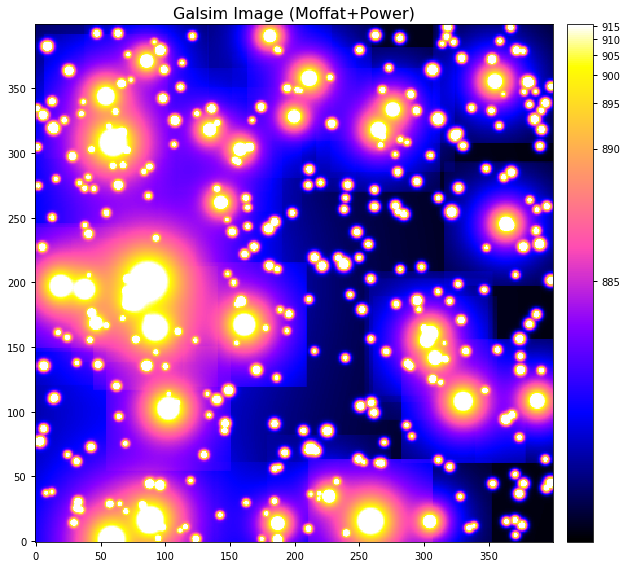

In [29]:
def generate_image_galsim(frac, n, mu, sigma, 
                          image_size=image_size,
                          min_psf_size=32, 
                          max_psf_size=384,
                          parallel=False):
    
    psf_pow, psf_size = Generate_PSF_pow_Galsim(contrast=1e4, n=n, 
                                                psf_scale=pixel_scale, psf_size=None,  
                                                min_psf_size=min_psf_size, max_psf_size=max_psf_size,
                                                x_interpolant="linear", k_interpolant="linear")    
    # Setup the canvas
    full_image = galsim.ImageF(image_size, image_size)
    
    # Draw medium bright stars with galsim in Fourier space
    psf_star = (1-frac) * psf_mof + frac * psf_pow               
    
    if not parallel:
        # Draw in serial
        for k in range(num_medbright):
            draw_star(k, star_pos=star_pos[medbright], Flux=Flux[medbright],
                      psf_star=psf_star, psf_size=psf_size,
                      full_image=full_image)
    else:
        # Draw in parallel, automatically back to serial computing if too few jobs 
        p_get_stamp_bounds = partial(get_stamp_bounds,
                                     star_pos=star_pos[medbright],
                                     Flux=Flux[medbright],
                                     psf_star=psf_star,
                                     psf_size=psf_size,
                                     full_image=full_image)
        
        results = parallel_compute(np.arange(num_medbright), p_get_stamp_bounds, 
                                   lengthy_computation=False, verbose=False)

        for (stamp, bounds) in results:
            full_image[bounds] += stamp[bounds]
           
    # Draw very bright star in real space / Fourier space       
    if (n < 2.5) | (image_size<500):
        draw_real = True
    else: 
        draw_real = False
                   
    if draw_real:
        # Draw very bright star (if highter cost in FFT) in real space
        image_gs = full_image.array
        for (pos, flux) in zip(star_pos[verybright], Flux[verybright]):
            p2d_vb = trunc_power2d(xx, yy, n, cen=(pos[0],pos[1]),
                                   theta0=theta_t_pix, I_theta0=frac*flux * (n-2)/n /theta_t_pix**2/np.pi)
            image_gs += p2d_vb
    else:
        # Draw very bright star in Fourier space 
        psf_pow_vb , psf_size = Generate_PSF_pow_Galsim(contrast=1e6, n=n, 
                                                        psf_scale=pixel_scale, psf_size=None,  
                                                        min_psf_size=2*min_psf_size, max_psf_size=2*max_psf_size,
                                                        x_interpolant="cubic", k_interpolant="cubic")
        psf_star = (1-frac) * psf_mof + frac * psf_pow_vb 
                              
        for k in range(num_verybright):
            draw_star(k, star_pos=star_pos[verybright], Flux=Flux[verybright],
                      psf_star=psf_star, psf_size=psf_size, full_image=full_image)
            
        image_gs = full_image.array
                   
    image = image_gs.copy() + image_gs0 + mu # add the faint star base and background

    return image

if draw:
    start = time.time()
    image_tri = generate_image_galsim(frac=frac, n=3., mu=mu, sigma=sigma, parallel=False)
    end = time.time()
    print("\nTotal Time: %.3fs"%(end-start))

    plt.figure(figsize=(9,8))
    im = plt.imshow(image_tri, vmin=mu, vmax=mu+10*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
    plt.title("Galsim Image (Moffat+Power)")
    colorbar(im)
    plt.tight_layout()   
    if save:
        plt.savefig("%s/Mock.png"%dir_name,dpi=150)
        plt.close()

Truths:  [-8.240e-01  3.000e+00  8.840e+02  3.162e+00]


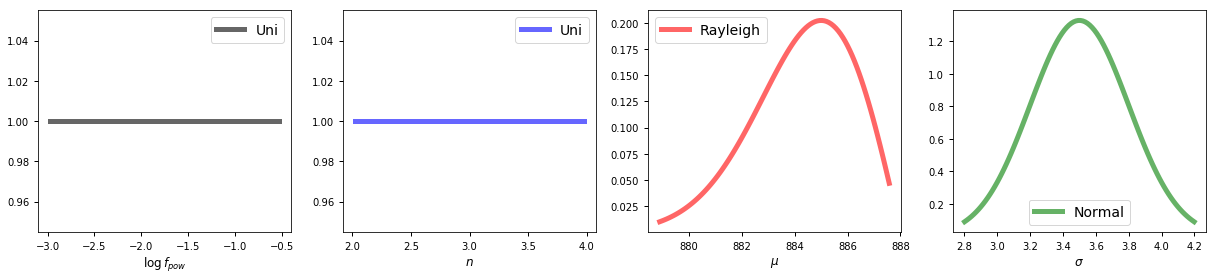

In [30]:
############################################
# Priors and Likelihood Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp

truths = np.log10(frac), n, mu, sigma
labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
print("Truths: ", np.around(truths, 3))

def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 2.7 - 3 # frac : 0.001-0.5
    v[1] = u[1] * 2 + 2  # n : 2-4
    v[2] = 888 - stats.rayleigh.ppf(u[2], loc=0, scale=3.)  # mu
    v[3] = stats.norm.ppf(u[3], loc=3.5, scale=0.3)  # sigma : N(5, 0.5)
    return v

if draw:
    dist1=stats.uniform()
    dist2=stats.rayleigh(loc=0, scale=3)
    dist3=stats.norm(loc=3.5, scale=0.3)

    x0,x1,x2,x3 = [np.linspace(d.ppf(0.01), d.ppf(0.99), 100) for d in (dist1,dist1,dist2,dist3)]

    fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(17,4))
    ax0.plot((x0 * 2.5 - 3), dist1.pdf(x0),'k-', lw=5, alpha=0.6, label='Uni')
    ax1.plot(x1*2+2, dist1.pdf(x1),'b-', lw=5, alpha=0.6, label='Uni')
    ax2.plot(888-x2, dist2.pdf(x2),'r-', lw=5, alpha=0.6, label='Rayleigh')
    ax3.plot(x3, dist3.pdf(x3),'g-', lw=5, alpha=0.6, label='Normal')
    for ax, xlab in zip((ax0,ax1,ax2,ax3), ["$\log\,f_{pow}$", "$n$", "$\mu$", "$\sigma$"]):
        ax.legend()
        ax.set_xlabel(xlab, fontsize=12)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Prior.png"%dir_name,dpi=150)
        plt.close('all')
        

if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike(v):
    logfrac, n, mu, sigma = v
    frac = 10**logfrac
    
    image_tri = generate_image_galsim(frac, n, mu, sigma, image_size=image_size)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike=loglike, 
                       prior_transform=prior_transform, 
                       ndim=4, truths=truths, 
                       nlive_init=200, nlive_batch=100, maxbatch=3,
                       print_progress=True):
        
    with mp.Pool(processes=n_cpu-1) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=print_progress, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

Opening pool: # of CPU used: 3


iter: 5492 | batch: 3 | bound: 55 | nc: 2 | ncall: 19736 | eff(%): 27.827 | loglstar: -184195.061 < -184191.049 < -184191.098 | logz: -184208.517 +/-  0.398 | stop:  3.367                           


Finish Fitting! Total time elapsed: 2.01e+03s


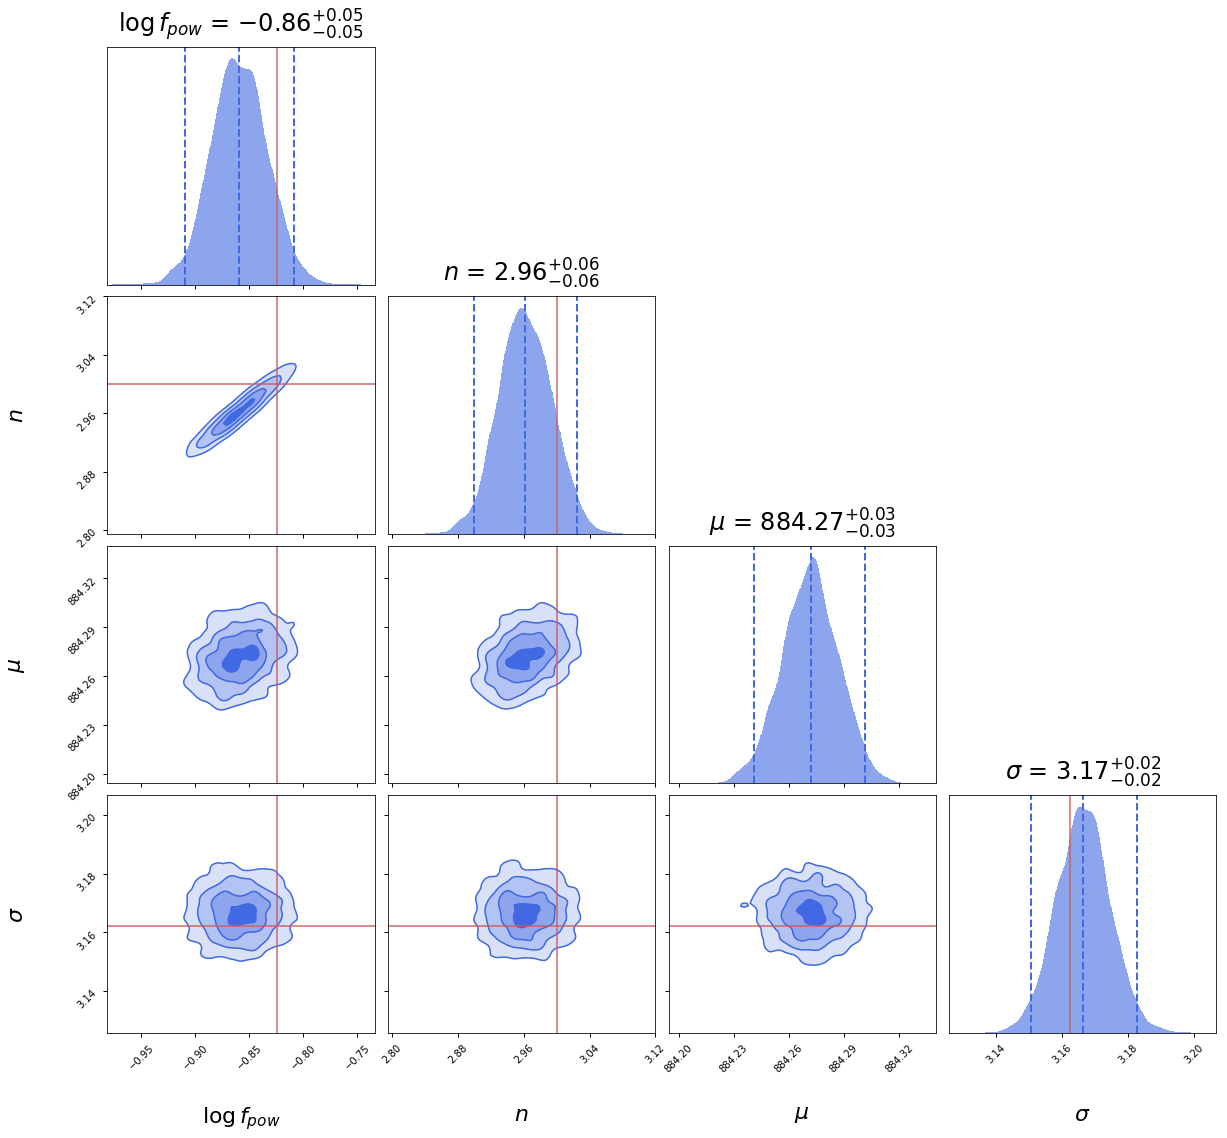

In [31]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike, prior_transform, truths=truths)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results
    save_nested_fitting_result(pdres, filename='%s/fit.res'%dir_name)
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':22},
                                  fig=plt.subplots(4, 4, figsize=(18, 16)))
    if save:
        plt.savefig("%s/Result.png"%dir_name,dpi=150)
        plt.close('all')
                   

In [64]:
def plot_fitting_vs_truth_PSF(res, true_pars, image_size=image_size, 
                              n_bootstrap=200, save=True, dir_name="."):
    
    pmed, pmean, pcov = get_params_fit(res) 
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    gamma, alpha, frac, n = true_pars.values()
    
    C_mof2Dto1D =  1./(beta_psf-1) * 2*math.sqrt(np.pi) * gamma_pix * Gamma(beta_psf) / Gamma(beta_psf-1./2) 
    C_pow2Dto1D = np.pi * theta_t_pix * (n-1) / (n-2)
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma, alpha=alpha) / C_mof2Dto1D
    comp2 = trunc_power1d_normed(r, n, theta_t_pix) / C_pow2Dto1D
    
    plt.figure(figsize=(7,6))
    
    plt.plot(r, np.log10((1-frac) * comp1 + frac * comp2),
                 label="Truth", color="steelblue", lw=4, zorder=2)
    for (logfrac_k, n_k, _, _) in samples_eq_bs:
        frac_k = 10**logfrac_k
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) / C_pow2Dto1D

        plt.plot(r, np.log10((1-frac_k) * comp1 + frac_k * comp2_k),
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            f_fit = 10**fits[0]
            comp2 = trunc_power1d_normed(r, fits[1], theta_t_pix) / C_pow2Dto1D
            y_fit = (1-f_fit) * comp1 + f_fit * comp2
            
            plt.plot(r, np.log10(y_fit), color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.plot(r, np.log10((1-f_fit) * comp1),
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.plot(r, np.log10(f_fit * comp2),
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
    
    plt.legend(fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm \log\,Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(-7, -0.5)
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()

Fitting (mean):  [-8.59056231e-01  2.96204544e+00  8.84271673e+02  3.16641128e+00]
Fitting (median):  [-8.59265986e-01  2.96161874e+00  8.84272081e+02  3.16646105e+00]
Fitting (highest weight):  [-7.96630555e-01  3.03680941e+00  8.84263459e+02  3.15888857e+00]


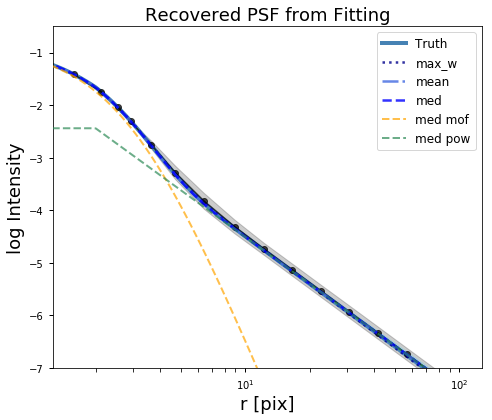

In [65]:
plot_fitting_vs_truth_PSF(pdres, n_bootstrap=300, image_size=image_size, save=False, dir_name=dir_name,
                          true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac, "n":n})
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pixel_scale, seeing=2.5, color="k",   
                                             core_undersample=True,xunit="pix", yunit="intensity", label="Galsim PSF")
